In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from anndata import AnnData
import scanpy as sc
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from cov import util, viz

sns.set(style="ticks", palette="tab10")

# load data and make adata object

In this dataset K5-Cre lineage traced cells were FACS-purified via YFP reporter expression at the following timepoints post methimazole: 24 Hours Post Injury (HPI); 48HPI; 96HPI; 7DPI; 14DPI.

To run this notebook, download the `GSE157068_countMatrix_k5.csv.gz`count files from the NCBI GEO at [GSE157068](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE157068) and save them to `data/raw/GSE157068_K5`. The associated metadata is already provided in `data/tables`.

In [3]:
data_folds = util.get_data_folders()
hbc_fold = util.get_raw_folders("mouse_HBC")

In [4]:
ad_fn = data_folds.processed / "Mouse_HBC.h5ad"
save = True
if ad_fn.exists():
    print("Loading h5ad file")
    adata = sc.read(ad_fn)
else:
    df_meta = pd.read_csv(
        data_folds.tables / "GSE157068_Brann_covid_metadata.csv.gz", index_col=0
    )
    df_counts = pd.read_csv(
        hbc_fold / "GSE157068_countMatrix_k5.csv.gz", low_memory=False, index_col=0
    )
    assert df_meta.index.isin(df_counts.columns).all()
    adata = AnnData(df_counts[df_meta.index].T)
    adata.var_names_make_unique()
    adata.X = sparse.csr_matrix(adata.X)

    adata.obs = df_meta.copy()
    adata.obsm["X_umap"] = df_meta[["UMAP_1", "UMAP_2"]].values

    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)

    if save:
        print(f"Saving h5ad file to {ad_fn}")
        adata.write_h5ad(ad_fn)
print(adata)

Loading h5ad file
AnnData object with n_obs × n_vars = 21722 × 14618
    obs: 'UMAP_1', 'UMAP_2', 'timepoint', 'batch', 'cell_type', 'cluster'
    obsm: 'X_umap'


# make example plots

In [5]:
clust_order = [
    "HBC",
    "HBC*",
    "GBC",
    "INP",
    "iOSN",
    "mOSN",
    "SUS",
    "MV Ionocyte-like",
    "Resp. HBC",
    "Resp. Secretory",
]
color_dict = viz.hbc_colors()

(-12.414777475, 15.474599975, -9.92191965, 15.79237665)

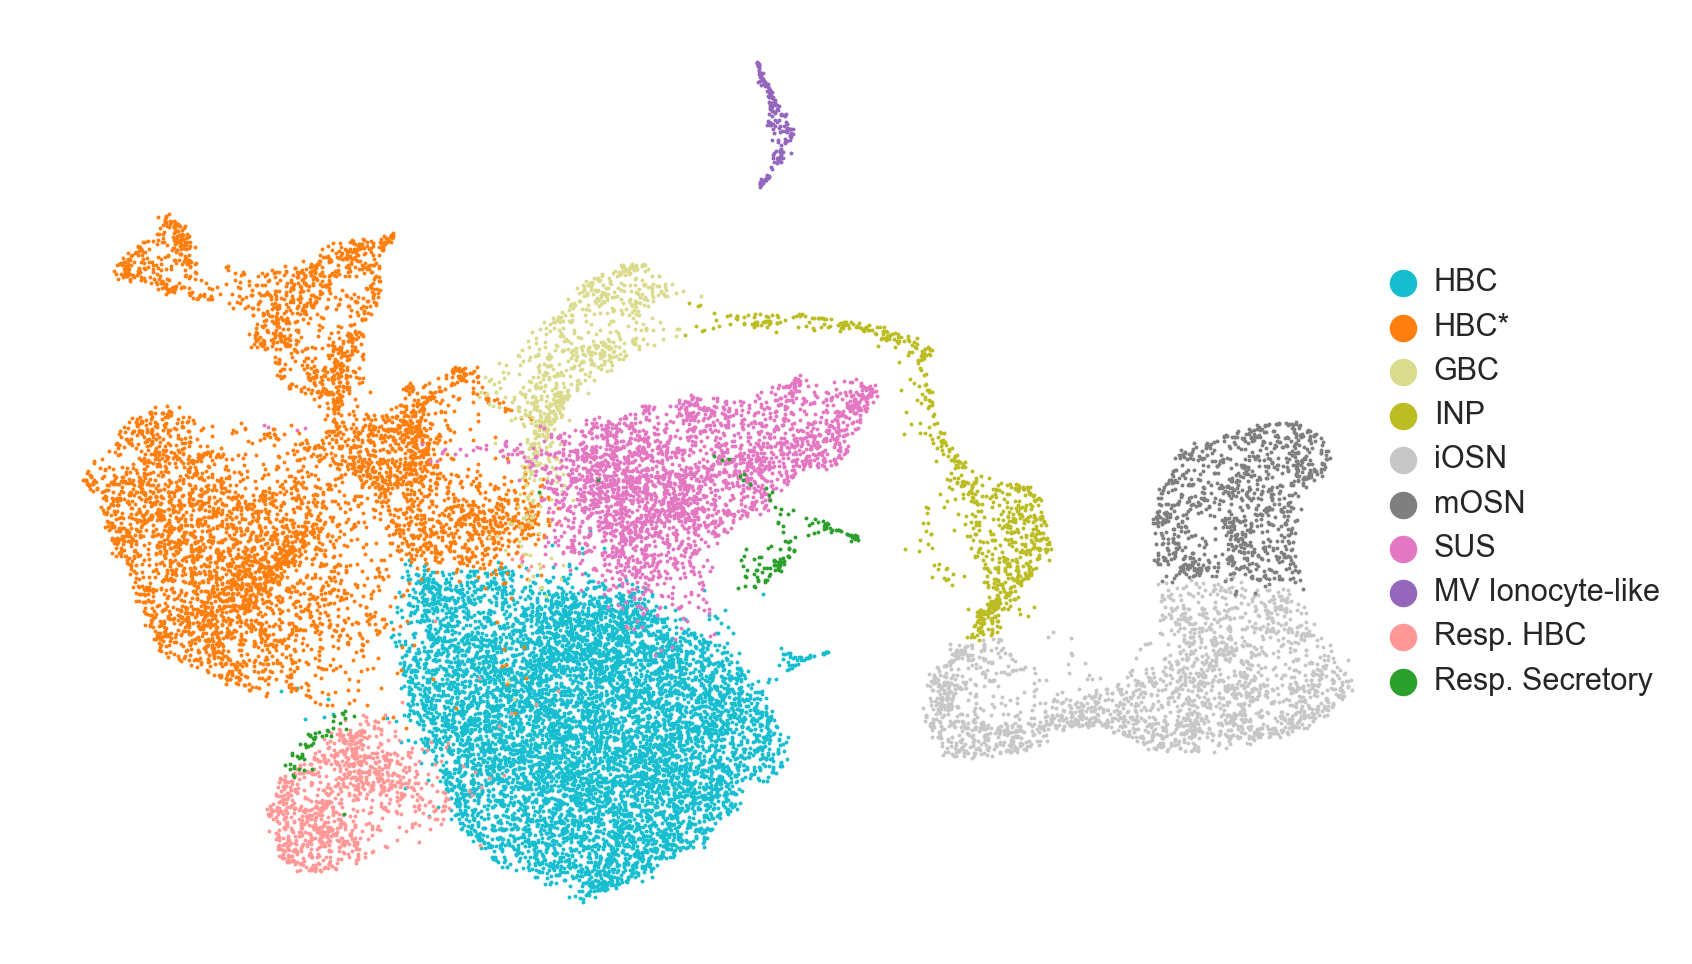

In [6]:
x, y = adata.obsm["X_umap"].T

fig, ax = plt.subplots(figsize=(9, 6))

for i, c in enumerate(clust_order):
    is_cell = adata.obs.cell_type == c
    this_x = x[is_cell]
    this_y = y[is_cell]
    ax.scatter(
        this_x,
        this_y,
        label=c,
        s=2,
        alpha=1,
        lw=0,
        color=color_dict[c],
        rasterized=True,
    )
ax.legend(
    markerscale=7,
    ncol=1,
    loc="center left",
    bbox_to_anchor=(0.95, 0.5),
    columnspacing=0,
    handletextpad=0,
    frameon=False
)
ax.axis("off")

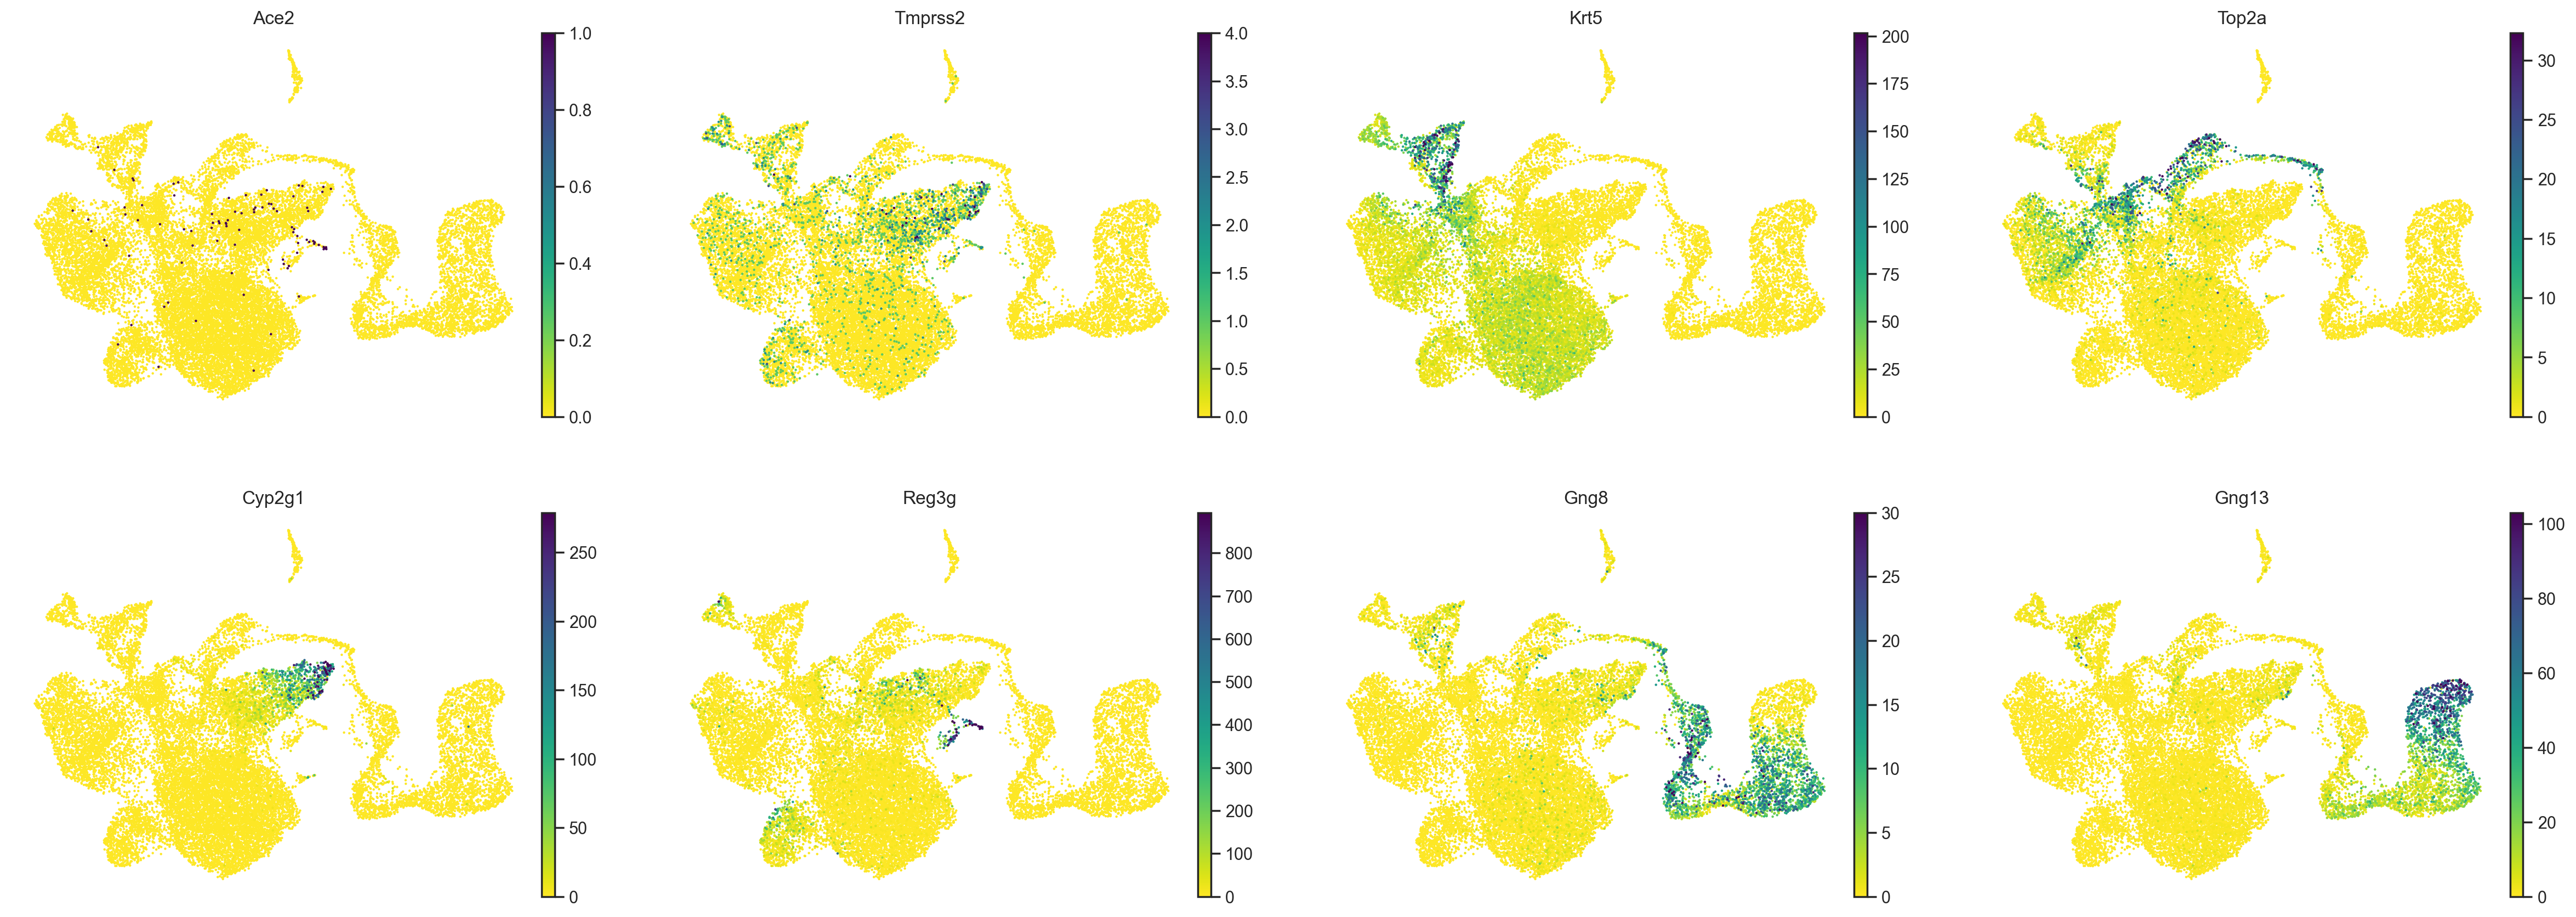

In [8]:
example_genes = ["Ace2", "Tmprss2", "Krt5", "Top2a", "Cyp2g1", "Reg3g", "Gng8", "Gng13"]

sc.pl.umap(
    adata,
    color=example_genes,
    ncols=4,
    cmap="viridis_r",
    vmax="p99.9",
    frameon=False,
    s=10)

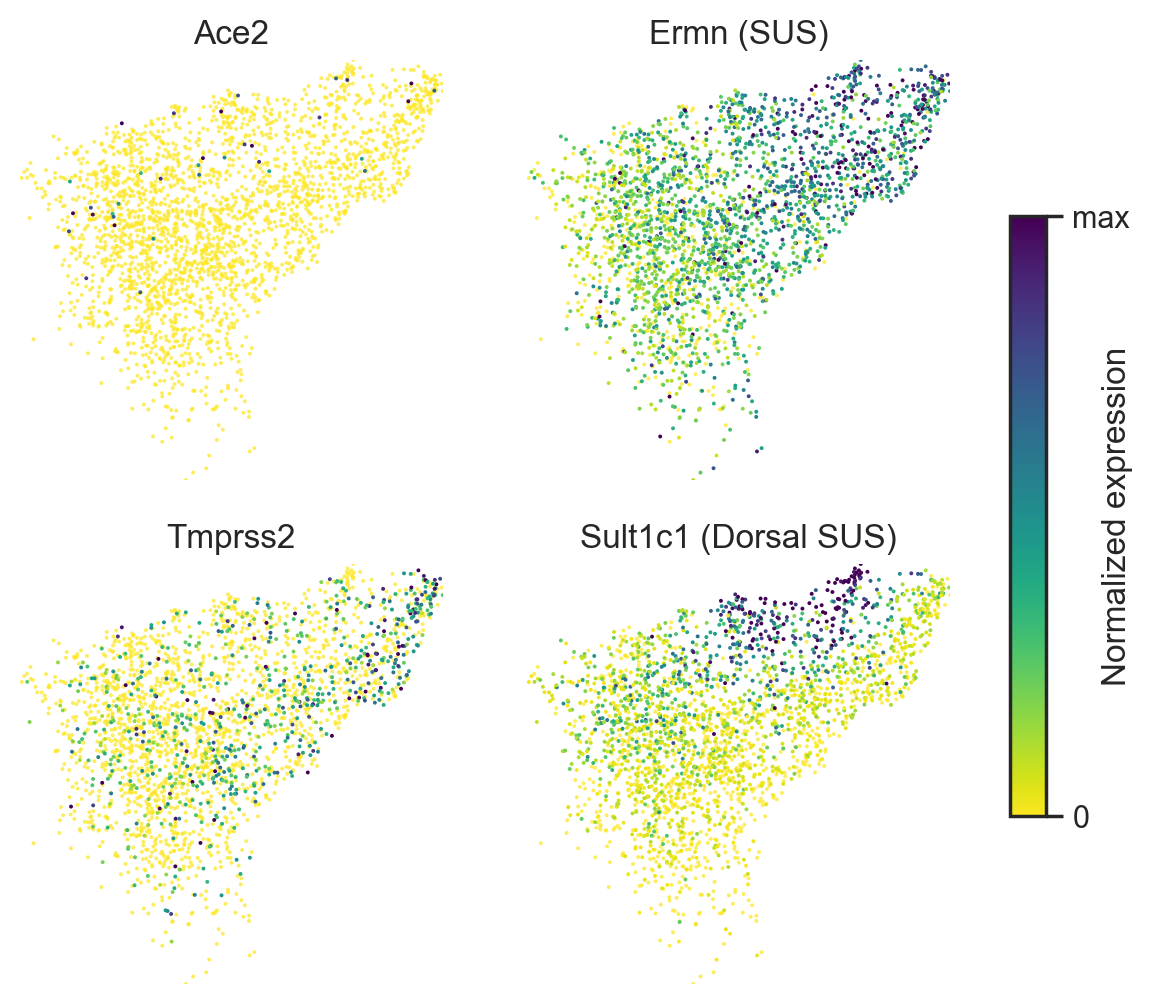

In [9]:
adata_sus = adata[
    (adata.obs.cell_type == "SUS") & (adata.obs.timepoint != "24HPI")
].copy()
genes = ["Ace2", "Ermn", "Tmprss2", "Sult1c1"]
df_gene = sc.get.obs_df(adata_sus, genes)
xs, ys = adata_sus.obsm["X_umap"].T

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

titles = ["Ace2", "Ermn (SUS)", "Tmprss2", "Sult1c1 (Dorsal SUS)"]

for i, (ax, gn, title) in enumerate(zip(axes.flatten(), genes, titles)):
    C = df_gene[gn]
    is_zero = C == 0
    vmax = np.percentile(C[C > 0], 95)
    if gn == "Ace2":
        vmax = 1
    ax.scatter(
        xs[is_zero],
        ys[is_zero],
        c=C[is_zero],
        s=2,
        cmap=plt.cm.viridis_r,
        vmin=0,
        vmax=vmax,
        lw=0,
        alpha=0.75,
        rasterized=True,
    )
    scatter = ax.scatter(
        xs[~is_zero],
        ys[~is_zero],
        c=C[~is_zero],
        s=2,
        cmap=plt.cm.viridis_r,
        vmin=0,
        vmax=vmax,
        lw=0,
        alpha=1,
        rasterized=True,
        zorder=10,
    )
    ax.axis("off")
    ax.set_title(title)
    if gn == "Ermn":
        viz.add_cbar(fig, scatter, pos=[0.95, 0.25, 0.03, 0.5])
    ax.set_xlim(np.percentile(xs, [1, 100]))
    ax.set_ylim(np.percentile(ys, [0, 100]))

In [10]:
cov_genes = [
    "Ace2",
    "Tmprss2",
    "Ctsb",
    "Ctsl",
    "Bsg",
    "Hspa5",
    "Dpp4",
    "Furin",
    "Anpep",
    "Tmprss11d",
    "St6gal1",
    "St3gal4",
    "Ceacam1",
]
genes_of_interest = [
    "Krt5",
    "Krt14",
    "Krt6a",
    "Cxcl14",
    "Ascl1",
    "Neurod1",
    "Gng8",
    "Gng13",
    "Cyp2g1",
    "Cftr",
    "Adh7",
    "Muc5b",
]

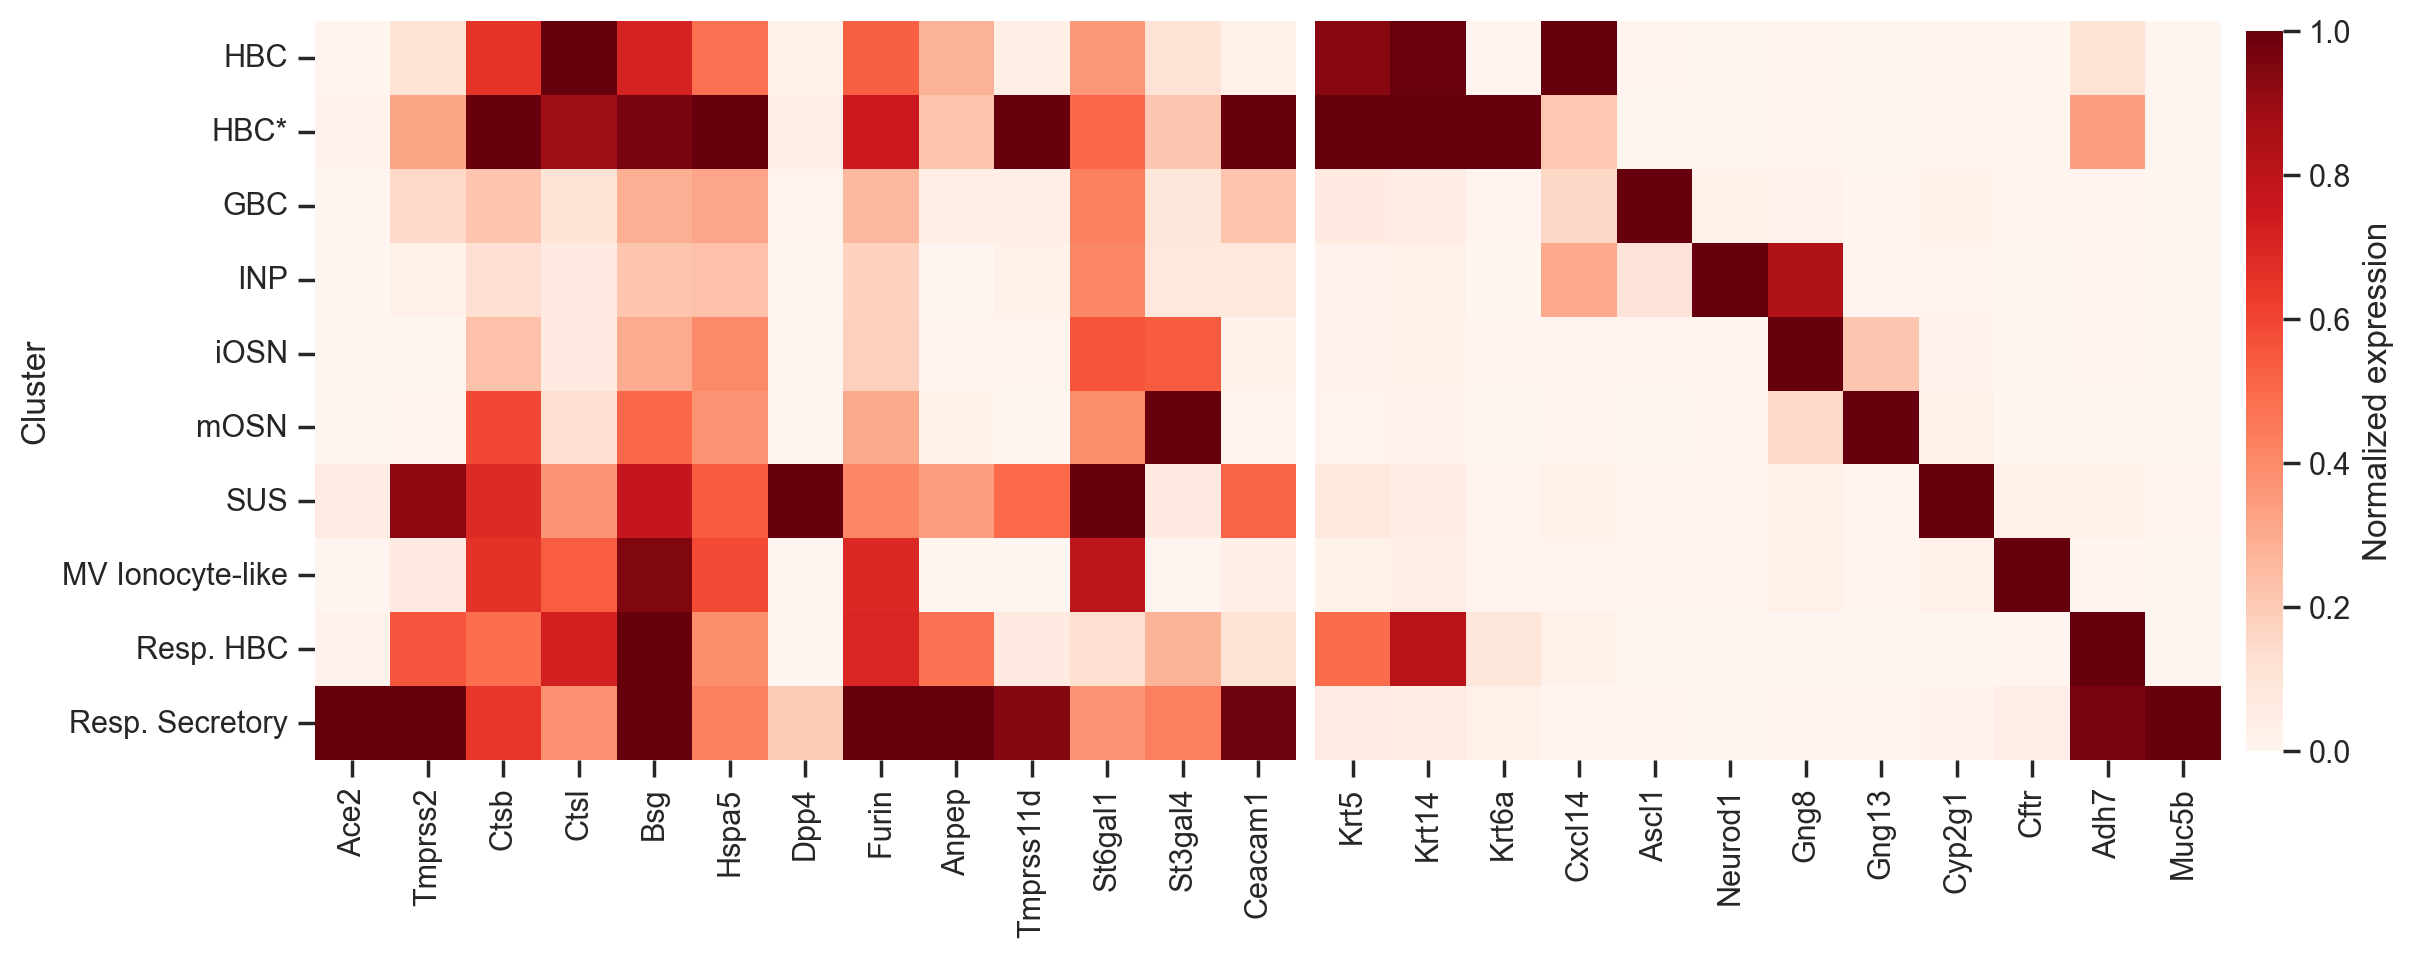

In [11]:
df_norm = viz.plot_heatmap(
    adata, genes_of_interest, cov_genes, clust_order, clust="cell_type"
)

Ace2    Tmprss2
cell_type                             
GBC                0.000000   7.947020
HBC                0.115652   3.495245
HBC*               0.387597  10.834256
INP                0.000000   0.763359
MV Ionocyte-like   0.000000   1.704545
Resp. HBC          0.207469  12.033195
Resp. Secretory   13.872832  29.479769
SUS                1.275319  25.768942
iOSN               0.000000   0.096479
mOSN               0.000000   0.322928

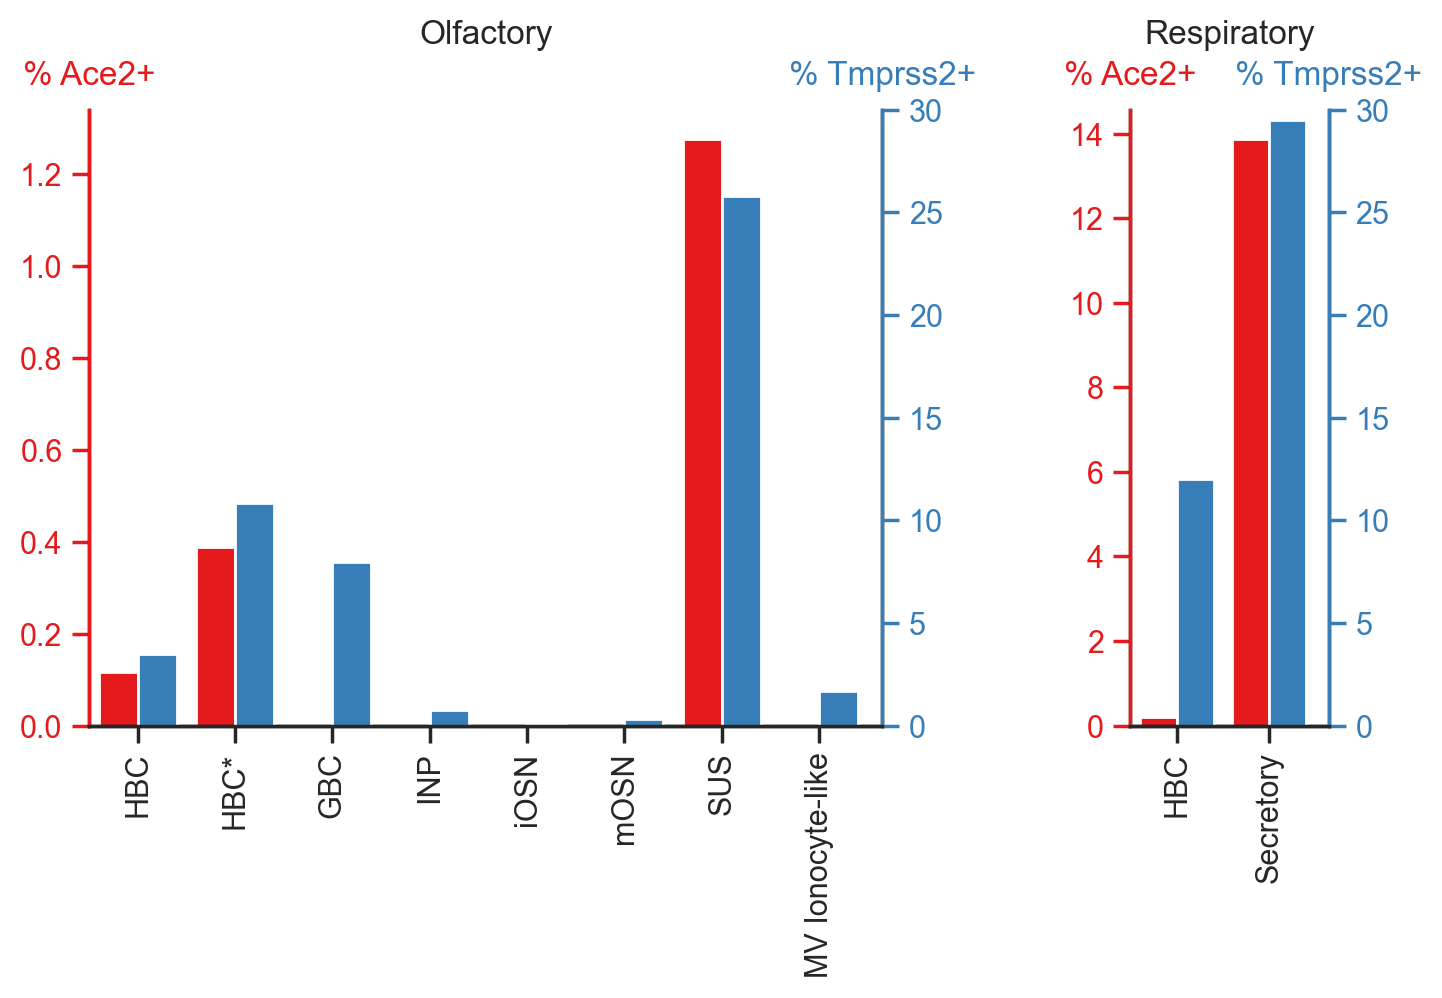

In [12]:
clusts = (clust_order[:-2], clust_order[-2:])
xl = tuple([cc.lstrip("Resp. ") for cc in c] for c in clusts)
df_pct = viz.make_bar_plot(
    adata,
    clusts,
    xl,
    mouse=True,
    clust="cell_type",
    ylims=(None, 30),
)
df_pct